# Connectivity Analysis - Single Subject Report

Connectivity...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mne.viz.set_3d_backend('pyvistaqt')

Using pyvistaqt 3d backend.



In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

#report = prep_report(conds, sides, perfs)

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

# CDA Channels
chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

clusters = ['F', 'P', 'C', 'O', 'T']
clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal'}


# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Epochs variable!
preproc_dict_all = dict()
events_dict_all = dict()
epochs_dict_all = dict()
rt_dict_all = dict()


In [2]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub TEMP 2/'

#filepath = directory_path + 'M22F2.bdf'
for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind('/')+1:]
    
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M1_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'M8M2_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9F2_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('/')+1] + 'T9M1_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'    

    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Bad channels - manual removal...
    # Subject T23F1.bdf: PO4
    # Subject T18F2.bdf: Iz
    #raw = raw.drop_channels('PO4')
    #raw = raw.drop_channels('Iz')

    # Sampling Frequency
    sfreq = raw.info['sfreq']
    
    preproc = raw

    # Events 
    events = find_events(preproc)

    # ---------- Debug Logs ----------
    frequency = collections.Counter(events[:,2])
    events_frequency = dict(frequency)

    print('Max Events in File...')
    print("---------------------------")
    for e in set(events[:,2]):
        print("{}: \t\t{}".format(e, frequency[e]))
    print("---------------------------")
    # ---------- Debug Logs ----------

    df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            if (nb_trials + 1) % 10 == 0:
                print('Check Synch!')

    # Calculate average response time.
    resp_time_in_ticks = []
    for i, e in enumerate(events):
        if e[2] == 8:
            if events[i+1,2] == 32:
                resp_time_in_ticks.append(events[i+1,0] - events[i,0])
            elif events[i+1,2] == 16: #Synch?!
                if events[i+2,2] == 32:
                    resp_time_in_ticks.append(events[i+2,0] - events[i,0])
                else:
                    print('No Response?! Trigger: {}'.format(events[i+1,2]))
            else:
                print('No Response?! Trigger: {}'.format(events[i+1,2]))

    mean_rt = np.mean(resp_time_in_ticks)
    median_rt = np.median(resp_time_in_ticks)
    std_rt = np.std(resp_time_in_ticks)
    print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))
    
    print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

    preproc_dict_all[filename] = preproc
    events_dict_all[filename] = new_events
    rt_dict_all[filename] = (mean_rt, median_rt, std_rt)

# Save All Subjects' Data
data_pickle = dict()
data_pickle['preproc'] = preproc_dict_all
data_pickle['events'] = events_dict_all

with open("AllSubs-raw.pkl","wb") as f:
    pickle.dump(data_pickle, f)

NameError: name 'glob' is not defined

In [105]:
with open("AllSubs-raw.pkl", "rb") as f:
    data_pickle = pickle.load(f)
    
preproc_dict_all = data_pickle['preproc']
events_dict_all = data_pickle['events']

len(preproc_dict_all)

Max Events in File...
---------------------------
32: 		78
1: 		153
2: 		75
4: 		75
8: 		75
16: 		3
---------------------------


Running autoreject on ch_type=eeg


100%|█████████████████████████████| Creating augmented epochs : 64/64 [00:42<00:00,    1.50it/s]
100%|██████████████████████████████| Computing thresholds ... : 64/64 [11:59<00:00,   11.24s/it]


  0%|                                           | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  5%|██                                     | Repairing epochs : 4/75 [00:00<00:00,  224.54it/s]

 11%|████▏                                  | Repairing epochs : 8/75 [00:00<00:00,  219.06it/s]

 16%|██████                                | Repairing epochs : 12/75 [00:00<00:00,  216.95it/s]

 21%|████████                              | Repairing epochs : 16/75 [00:00<00:00,  216.39it/s]

 25%|█████████▋                            | Repairing epochs : 19/75 [00:00<00:00,  205.26it/s]

 31%|███████████▋                          | Repairing epochs : 23/75 [00:00<00:00,  206.85it/s]

 36%|█████████████▋                        | Repairing epochs : 27/75 [00:00<00:00,  207.98it/s]

 41%|███████████████

 63%|███████████████████████▊              | Repairing epochs : 47/75 [00:01<00:00,   31.77it/s]

 64%|████████████████████████▎             | Repairing epochs : 48/75 [00:01<00:00,   32.40it/s]

 65%|████████████████████████▊             | Repairing epochs : 49/75 [00:01<00:00,   31.75it/s]

 67%|█████████████████████████▎            | Repairing epochs : 50/75 [00:01<00:00,   32.08it/s]

 68%|█████████████████████████▊            | Repairing epochs : 51/75 [00:01<00:00,   32.29it/s]

 69%|██████████████████████████▎           | Repairing epochs : 52/75 [00:01<00:00,   32.50it/s]

 71%|██████████████████████████▊           | Repairing epochs : 53/75 [00:01<00:00,   32.64it/s]

 73%|███████████████████████████▊          | Repairing epochs : 55/75 [00:01<00:00,   34.34it/s]

 75%|████████████████████████████▎         | Repairing epochs : 56/75 [00:01<00:00,   34.03it/s]

 76%|████████████████████████████▉         | Repairing epochs : 57/75 [00:01<00:00,   34.20it/s]

 77%|███████████████





Estimated consensus=0.50 and n_interpolate=1




  0%|                                           | Repairing epochs : 0/75 [00:00<?,       ?it/s]

  3%|█                                      | Repairing epochs : 2/75 [00:00<00:01,   60.61it/s]

  4%|█▌                                     | Repairing epochs : 3/75 [00:00<00:01,   59.32it/s]

  5%|██                                     | Repairing epochs : 4/75 [00:00<00:01,   55.95it/s]

  7%|██▌                                    | Repairing epochs : 5/75 [00:00<00:01,   52.46it/s]

  8%|███                                    | Repairing epochs : 6/75 [00:00<00:01,   52.11it/s]

  9%|███▋                                   | Repairing epochs : 7/75 [00:00<00:01,   52.79it/s]

 11%|████▏                                  | Repairing epochs : 8/75 [00:00<00:01,   53.05it/s]

 12%|████▋                                  | Repairing epochs : 9/75 [00:00<00:01,   54.00it/s]

 13%|█████                                 | Repairing epochs : 10/75 [00:00<00:01,   54.68it/s]

 15%|█████▌       

Dropped 4 epochs: 6, 32, 46, 70


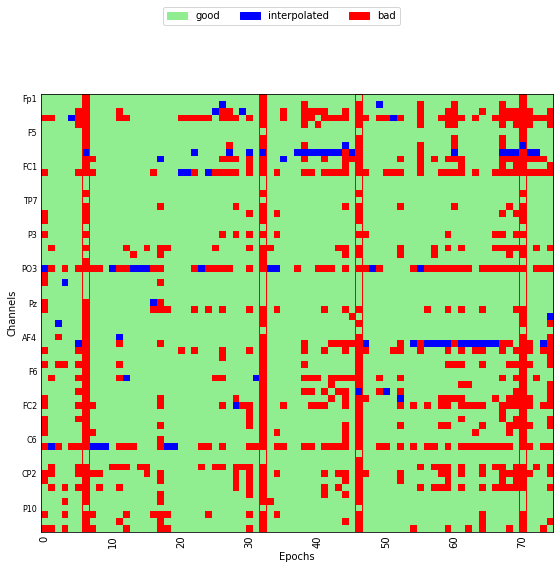

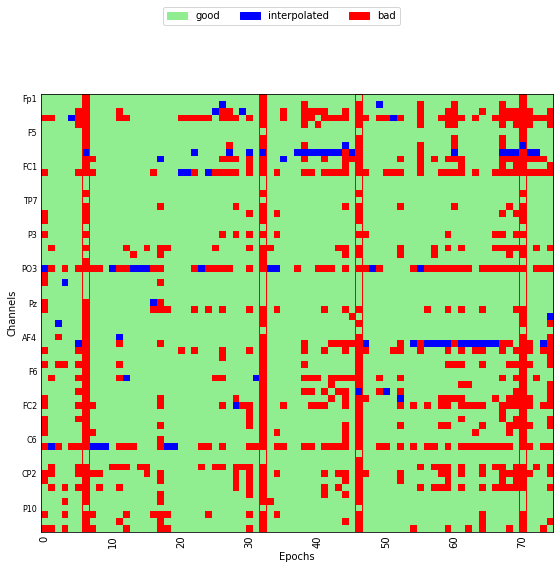

In [112]:
ar = AutoReject()
epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
fig, ax = plt.subplots(figsize=(15,8))
reject_log.plot('horizontal', ax=ax)

# Add Cleaning Log to Report

In [1]:
# Adding Response Time to Report
#substr = '<p> Response Time: Mean= {:.2f}s | Median= {:.2f}) | Std= {:.2f} </p>'.format(mean_rt/sfreq, std_rt/sfreq, median_rt/sfreq)
#report_subj.add_html(substr, 'Subject Recall/Answer Time')

phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}
times_phase = dict()

#cda_phase_cluster_sides_all = dict()
#cda_phase_cluster_sizes_all = dict()
#cda_phase_cluster_perfs_all = dict()

for participant in preproc_dict_all.keys():
    #cda_phase_cluster_sides_all[participant] = dict()
    #cda_phase_cluster_sizes_all[participant] = dict()
    #cda_phase_cluster_perfs_all[participant] = dict()
    
    events = events_dict_all[participant]
    preproc = preproc_dict_all[participant]

    # -- Prep MNE-Report --
    report_subj = mne.Report(title='Subject Report Raw Frequency - {}'.format(participant))
    report_subj_filename = 'Subject_Report-{}.html'.format(participant[:-4])

    print('==================================================')
    print('REMOVING EVENTS ID NOT IN EEG FILE...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events_dict_all[participant])[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================')   
        
    epochs = Epochs(preproc, events, event_id=cur_event_id, tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')
    
    print('Adding raw to report...')
    report_subj.add_raw(raw=preproc.pick_types(eeg=True), butterfly=False, title='Raw', tags=('General',))

    print('Adding epochs to report...')
    report_subj.add_epochs(epochs=epochs, title='Epochs', tags=('General',))
    
    # ================================
    # TODO: Add Evokeds to MNE-Report
    # ================================
    

    print('Saving report...')
    report_subj.save(report_subj_filename, overwrite=True, open_browser=False)

    print(f'{participant} - Done!')

#times = epochs.copy().crop(tmin=tmin, tmax=tmax).times

NameError: name 'preproc_dict_all' is not defined

# Connectivity

In [127]:
from mne_connectivity import spectral_connectivity
from mne_connectivity.viz import plot_sensors_connectivity

# Compute connectivity for band containing the evoked response.
# We exclude the baseline period:
fmin, fmax = 75, 85.
sfreq = raw.info['sfreq']  # the sampling frequency
tmin = 0.0  # exclude the baseline period
epochs.pick_types(eeg=True)  # just keep MEG and no EOG now
con = spectral_connectivity(epochs['right'].copy().crop(tmin=10.5, tmax=13.5), method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8)

# Now, visualize the connectivity in 3D:
fig = plot_sensors_connectivity(epochs.info, con.get_data(output='dense')[:, :, 0], cbar_label='Connectivity')

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=10.500s..13.500s for estimation (6145 points)
    frequencies: 75.3Hz..85.0Hz (30 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..8


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_78279/3467086375.py:10: RuntimeWarning: start time tmin=0.00 s outside of the time scope of the data [10.50 s, 13.50 s]
  con = spectral_connectivity(epochs['right'].copy().crop(tmin=10.5, tmax=13.5), method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin, fmax=fmax,
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s


    computing connectivity for epochs 9..16
    computing connectivity for epochs 17..24


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    computing connectivity for epochs 25..26
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.1s finished
Context leak detected, msgtracer returned -1


In [ ]:
import os.path as op
import mne

sample_path = mne.datasets.sample.data_path()
subjects_dir = op.join(sample_path, 'subjects')
fname_evoked = op.join(sample_path, 'MEG', 'sample', 'sample_audvis-ave.fif')
fname_inv = op.join(sample_path, 'MEG', 'sample',
                    'sample_audvis-meg-oct-6-meg-inv.fif')
fname_trans = op.join(sample_path, 'MEG', 'sample',
                      'sample_audvis_raw-trans.fif')
inv = mne.minimum_norm.read_inverse_operator(fname_inv)
evoked = mne.read_evokeds(fname_evoked, baseline=(None, 0),
                          proj=True, verbose=False, condition='Left Auditory')
maps = mne.make_field_map(evoked, trans=fname_trans, ch_type='meg',
                          subject='sample', subjects_dir=subjects_dir)
time = 0.083
fig = mne.viz.create_3d_figure((256, 256))
mne.viz.plot_alignment(
    evoked.info, subject='sample', subjects_dir=subjects_dir, fig=fig,
    trans=fname_trans, meg='sensors', eeg=False, surfaces='pial',
    coord_frame='mri')
evoked.plot_field(maps, time=time, fig=fig, time_label=None, vmax=5e-13)
mne.viz.set_3d_view(
    fig, azimuth=40, elevation=87, focalpoint=(0., -0.01, 0.04), roll=-25,
    distance=0.55)

In [91]:
from mne.time_frequency import csd_fourier, csd_multitaper, csd_morlet

%matplotlib qt
z
#fig, ax = plt.subplots(figsize=(15,15))
csd_fft = csd_fourier(epochs['left'].copy().crop(tmin=10.5, tmax=13), fmin=2, fmax=90, n_jobs=1)
#csd_fft.mean().plot()
#csd_fft.pick_frequency(freq=80).plot()
csd_fft.mean().plot()

Computing cross-spectral density from epochs...


100%|██████████████████████████████████████| CSD epoch blocks : 30/30 [00:00<00:00,   30.05it/s]

[done]


[<Figure size 432x316 with 2 Axes>]